### Carga de datos

In [1]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('default')
sns.set()

In [3]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [4]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})

### Analisis duracion de sesion

In [5]:
df_indice_en_persona_evento = df.set_index(['person','event'])

In [6]:
dif_primer_ultimo_evento = df_indice_en_persona_evento.groupby('person').agg({'timestamp':['max', 'min']})
dif_primer_ultimo_evento['diferencia'] = dif_primer_ultimo_evento['timestamp']['max'] - dif_primer_ultimo_evento['timestamp']['min']
dif_primer_ultimo_evento.drop(columns='timestamp', inplace= True)
#mejora notoria de tiempo de ejecucion

In [7]:
dif_primer_ultimo_evento = dif_primer_ultimo_evento.loc[dif_primer_ultimo_evento['diferencia']>'1 day'].sort_values(by = 'diferencia')
pd.concat([dif_primer_ultimo_evento.head(), dif_primer_ultimo_evento.tail()])

,diferencia
,
person,
090de13e,1 days 00:02:28
c56e464b,1 days 00:02:34
482292d0,1 days 00:02:43
274c909c,1 days 00:03:07
20804569,1 days 00:03:11
9250d410,161 days 10:56:51
ce5f5942,161 days 19:59:42
8dc00e04,162 days 01:22:29


Text(0.5,1,'Distribución de duración de sesiones')

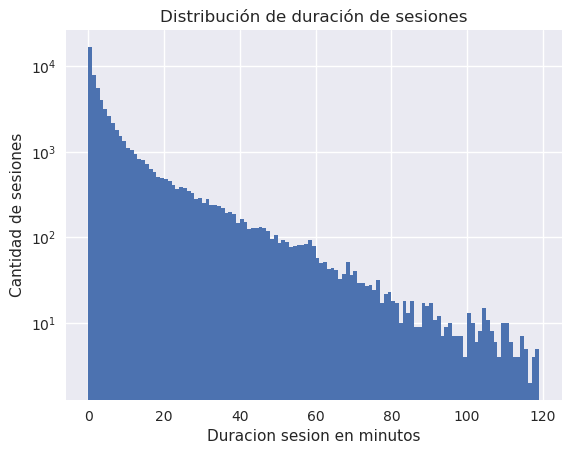

In [16]:
eventos_por_persona = df.loc[(df['event'] != 'ad campaign hit') & (df['event'] != 'search engine hit'), ['person', 'timestamp', 'event']].copy()
eventos_por_persona['nueva_sesion'] = eventos_por_persona['event'] == 'visited site'
eventos_por_persona['timestamp_normalizado'] = eventos_por_persona['timestamp'].dt.round(freq = '20S') #agrupa de a ciclos de 10 segundos

#dejamos solo un evento por persona para cada ciclo de 10 segundos, dejando siempre los visited site o el evento que tiene un timestamp mas posterior
#eventos_por_persona = eventos_por_persona.sort_values(by = ['nueva_sesion', 'timestamp'], ascending = [False, False]).drop_duplicates(subset = ['person', 'timestamp_normalizado'], keep = 'first')
eventos_por_persona = eventos_por_persona.sort_values(['person', 'timestamp'])

#borrar eventos aislados que no sean visited site
eventos_por_persona['sig_timestamp'] = eventos_por_persona['timestamp'].shift(-1)
eventos_por_persona['ant_timestamp'] = eventos_por_persona['timestamp'].shift(1)
eventos_por_persona['dist_timestamps_ant'] = abs(eventos_por_persona['timestamp'] - eventos_por_persona['ant_timestamp'])
eventos_por_persona['dist_timestamps_sig'] = abs(eventos_por_persona['timestamp'] - eventos_por_persona['sig_timestamp'])
eventos_por_persona = eventos_por_persona.loc[((eventos_por_persona['dist_timestamps_ant'] < pd.Timedelta('1 hours')) \
                                               & (eventos_por_persona['dist_timestamps_sig'] < pd.Timedelta('1 hours')) \
                                               | eventos_por_persona['nueva_sesion'])]


eventos_por_persona['sig_nueva_sesion'] = eventos_por_persona['nueva_sesion'].shift(-1) #nueva columna que indica el valor 'nueva_sesion' de la siguiente fila
eventos_por_persona = eventos_por_persona.loc[(eventos_por_persona['nueva_sesion'] | eventos_por_persona['sig_nueva_sesion'])]
eventos_por_persona['sig_timestamp'] = eventos_por_persona['timestamp'].shift(-1)
eventos_por_persona = eventos_por_persona.loc[eventos_por_persona['nueva_sesion']]

eventos_por_persona.loc[(eventos_por_persona['nueva_sesion'] & eventos_por_persona['sig_nueva_sesion']), 'sig_timestamp'] = eventos_por_persona.loc[(eventos_por_persona['nueva_sesion'] & eventos_por_persona['sig_nueva_sesion']), 'timestamp']

eventos_por_persona['duracion_sesion'] = eventos_por_persona['sig_timestamp'] - eventos_por_persona['timestamp']
eventos_por_persona = eventos_por_persona.loc[((eventos_por_persona['duracion_sesion'] > pd.Timedelta('0 days')) & (eventos_por_persona['duracion_sesion'] < pd.Timedelta('6 hours')))]

sesiones_minutos = pd.Series()
sesiones_minutos = eventos_por_persona['duracion_sesion'] / pd.Timedelta(minutes=1)
#sesiones_minutos
ax = sesiones_minutos.hist(bins = range(0, 120, 1))
ax.set_yscale('log')
ax.set_xlabel('Duracion sesion en minutos')
ax.set_ylabel('Cantidad de sesiones')
ax.set_title('Distribución de duración de sesiones')